In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data Exploration(I)

In [65]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [68]:
sum(train.isnull().sum()>1) #the number of columns that the train set has missing values

18

In [69]:
sum(test.isnull().sum()>1) #the number of columns that the test set has missing values

23

From above, we find that there are a lot columns with missing values, we need first to process the `missing values`

## Processing Missing Values

In [70]:
train.columns[train.isnull().sum()/len(train) > 0.05]

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [71]:
test.columns[test.isnull().sum()/len(test) > 0.05]

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

### Drop the the columns with missing values above 5%

In [72]:
# drop the columns with the missing values above the given threshold 
def drop_columns_with_missing_threshold(df, threshold=0.05):
    columns = df.columns[df.isnull().sum()/len(df) < threshold]
    return df[columns]

In [73]:
train = drop_columns_with_missing_threshold(train)

In [74]:
test = drop_columns_with_missing_threshold(test)

### Drop the missing values

In [75]:
def columns_with_missing(df):
    coloumns = df.columns[df.isnull().sum() != 0]
    return list(coloumns)

def display_missing_statistics(df):
    missing_columns = columns_with_missing(df)
    return df[missing_columns].isnull().sum()

In [76]:
display_missing_statistics(train)

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
dtype: int64

In [77]:
train[columns_with_missing(train)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MasVnrType    1452 non-null   object 
 1   MasVnrArea    1452 non-null   float64
 2   BsmtQual      1423 non-null   object 
 3   BsmtCond      1423 non-null   object 
 4   BsmtExposure  1422 non-null   object 
 5   BsmtFinType1  1423 non-null   object 
 6   BsmtFinType2  1422 non-null   object 
 7   Electrical    1459 non-null   object 
dtypes: float64(1), object(7)
memory usage: 91.4+ KB


In [79]:
train.dropna(inplace=True)

c:\users\test\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
train.shape

(1412, 70)

## Data Exploration(II)

### Split the train into the numerical and text features

In [82]:
numerical_features = train.select_dtypes(exclude=['object'])

In [102]:
text_features = train.select_dtypes(include=['object'])

### Investigate the correlation between Numerical features and the Target

In [103]:
numerical_features.corr()['SalePrice'].abs().sort_values()

MiscVal          0.013287
BsmtFinSF2       0.020196
BsmtHalfBath     0.022093
YrSold           0.023361
Id               0.024651
LowQualFinSF     0.028428
MoSold           0.041754
3SsnPorch        0.047040
MSSubClass       0.082281
PoolArea         0.092776
OverallCond      0.093567
KitchenAbvGr     0.105743
ScreenPorch      0.108208
EnclosedPorch    0.134342
BedroomAbvGr     0.170174
BsmtUnfSF        0.188959
BsmtFullBath     0.208756
LotArea          0.264803
HalfBath         0.270145
OpenPorchSF      0.304972
WoodDeckSF       0.317361
2ndFlrSF         0.317948
BsmtFinSF1       0.368849
Fireplaces       0.462937
MasVnrArea       0.474525
YearRemodAdd     0.500266
YearBuilt        0.518736
TotRmsAbvGrd     0.545540
FullBath         0.575604
TotalBsmtSF      0.611084
1stFlrSF         0.614753
GarageArea       0.621095
GarageCars       0.641825
GrLivArea        0.711080
OverallQual      0.786765
SalePrice        1.000000
Name: SalePrice, dtype: float64

**OverallQual Feature**

In [93]:
train['OverallQual'].value_counts()

5     381
6     371
7     313
8     166
4     103
9      43
10     17
3      14
2       3
1       1
Name: OverallQual, dtype: int64

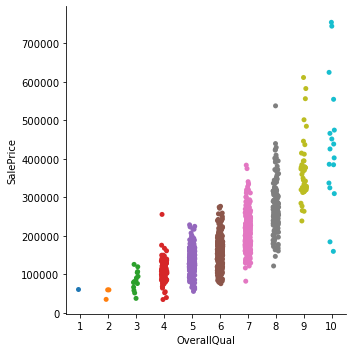

In [101]:
sns.catplot(x='OverallQual', y='SalePrice', data=train);

**GrLivArea Feature**

In [ ]:
train['GrLivArea']

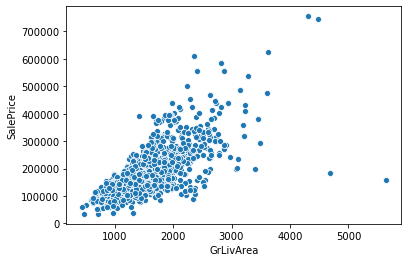

In [105]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train);

**GarageCars Feature**

In [106]:
train['GarageCars'].value_counts()

2    793
1    361
3    179
0     74
4      5
Name: GarageCars, dtype: int64

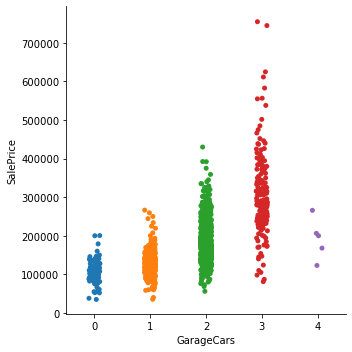

In [107]:
sns.catplot(x='GarageCars', y='SalePrice', data=train);

**GarageArea Feature**

In [108]:
train['GarageArea'].value_counts()

0       74
440     48
576     47
240     37
484     33
        ..
594      1
590      1
862      1
582      1
1418     1
Name: GarageArea, Length: 436, dtype: int64

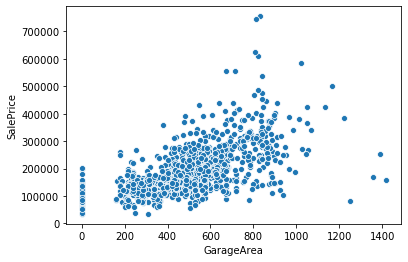

In [109]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train);

In [92]:
train.GarageCars.corr(train.GarageArea)

0.8806176075537999

From above, we can see GarageCars and GarageArea has strong correlationship, we will use GrageArea instead of both features.

### Use `OverallQual`、`GrLivArea`、`GarageArea` to have a  first try

In [110]:
X = train[['OverallQual', 'GrLivArea', 'GarageArea']]
y = train['SalePrice']

In [116]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

**Transform `OverallQual` to one-hot encoding**

In [121]:
X = create_dummies(X, 'OverallQual').drop(columns=['OverallQual'])

**Data Normalization**

In [138]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

**Model Selection**

In [177]:
def select_model(X, y):
    all_X = X
    all_y = y
    
    model_list = [
    # KNN
    {
    "name": "KNeighborsRegressor",
    "estimator": KNeighborsRegressor(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    },
    # XGBRegressor
    {
    "name": "XGBRegressor",
    "estimator": XGBRegressor(),
    "hyperparameters":
        {
            "n_estimators": [100, 500],
            "learning_rate": [0.05, 0.1, 0.5]
        }
    },
    # RandomForestRegressor
    {
    "name": "RandomForestRegressor",
    "estimator": RandomForestRegressor(),
    "hyperparameters":
        {
            "n_estimators": [100, 500],
            "max_depth": [None, 5, 10]
        }
    }
    ]
    
    for model in model_list:
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10, scoring='neg_mean_absolute_error')
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
    return model_list

In [178]:
result = select_model(X, y)

Best Score: -24014.74003706947
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

Best Score: -24115.817131545926
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 100}

Best Score: -24884.950449620188
Best Parameters: {'max_depth': 10, 'n_estimators': 500}



### Make a prediction on the test

In [195]:
def submission(predictions, file='submission.csv'):
    result = pd.DataFrame({'Id': range(1461, predictions.size+1461), 'SalePrice': predictions})
    result.to_csv(file, index=False)

In [184]:
X_test = test[['OverallQual', 'GrLivArea', 'GarageArea']]

In [187]:
X_test["GarageArea"] = X_test["GarageArea"].fillna(X_test['GarageArea'].mean())

c:\users\test\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
X_test.isnull().sum()

OverallQual    0
GrLivArea      0
GarageArea     0
dtype: int64

In [191]:
X_test = create_dummies(X_test, 'OverallQual').drop(columns=['OverallQual'])
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=X_test.columns)

In [193]:
predictions = result[0]['best_model'].predict(X_test)

In [196]:
submission(predictions, 'submission_knn.csv')

got a 23609.31944 score from kaggle

In [198]:
display_missing_statistics(test)

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
MasVnrType      16
MasVnrArea      15
BsmtQual        44
BsmtCond        45
BsmtExposure    44
BsmtFinType1    42
BsmtFinSF1       1
BsmtFinType2    42
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
KitchenQual      1
Functional       2
GarageCars       1
GarageArea       1
SaleType         1
dtype: int64

## Feature Engineering 